In [1078]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
base_path = Path('/Users/jastr/OneDrive/Desktop/dane-wakacyjne-wyzwanie') # Pass path to data folder here, e.g. Path('/content/drive/MyDrive/data') if using Google Drive

# Analiza i przetwarzanie danych na temat Titanica

#### Wyobraź sobie, że pewnego wakacyjnego dnia, będąc na plaży w pełnym słońcu, odbierasz telefon od nieznanego numeru.
Robisz to niechętnie — zasłużyłeś/aś przecież na odpoczynek i chcesz mieć ten czas tylko dla siebie. Już masz na końcu języka wymijającą odpowiedź, gdy nagle z drugiej strony słyszysz:
„Czy jesteś gotowy, by tego lata rozwikłać jedną z największych zagadek ludzkości?”

Jako osoba z natury ciekawa świata i ze świetnym umysłem analitycznym, szybko zapominasz o plaży i wakacjach. Zaintrygowany/a dopytujesz o szczegóły, ale rozmówca nie chce zdradzić zbyt wiele. Wiadomo jedynie, że chodzi o *zatonięcie Titanica w 1914* roku, a celem misji jest ustalenie, które osoby miały szansę przeżyć.

**Ty** — jako **renomowany analityk danych** — byłeś/byłaś ich pierwszym wyborem do analizy i oczyszczenia danych. Mimo wątpliwości postanawiasz podjąć się zadania, mając nadzieję, że twoja wiedza może zostać praktycznie wykorzystana w słusznym celu.

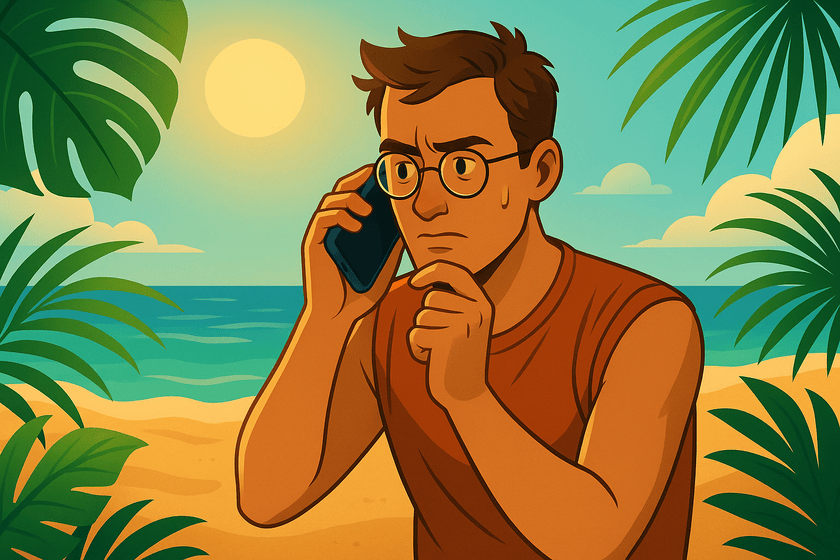

(*AI-generated image*)


#### Twoim celem będzie przeanalizowanie i przetworzenie zbioru danych w taki sposób, by mógł on być użyty do nauki modelu do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

(Uwaga: w tym zadaniu nie będziesz trenować modeli, ta przyjemność spotka cię w następnych notebookach)

Poniżej znajdziesz pytania, które mogą być pomocne w analizie, oraz odwołania do poszczególnych sekcji z notebooka do lekcji:

- Czy wszystkie kolumny są istotne w kontekście zadania?
- Czy występują brakujące wartości? Jeśli tak, to jak je uzupełnisz? (sekcja #2.1)
- Czy typy danych są odpowiednie do znaczenia kolumny? (sekcja #1.3)
- Czy dystrybucje danych mają rozkłady normalne, czy asymetryczne? (sekcja #4.1 + wykład)
- Która zmienna oznacza predykowaną klasę?
- Jaki jest rozkład zmiennej predykowanej względem zmiennych kategorialnych, jak i numerycznych? (sekcja #4.1)
- Czy końcowe rozkłady zawierają wartości skrajne? (sekcja #4.2 + wykład)

Wymagania:

- Zbiór musi być oczyszczony, tj. finalnie nie powinien mieć brakujących wartości (sekcja #2.1)
- Zbiór musi zawierać co najmniej dwie dodatkowe kolumny, które mogą wzbogacić informacje zawarte w zbiorze (sekcje #1.5 i #2.2)
- Cechy kategorialne powinny być zakodowane, postaraj się dobrać odpowiedni sposób (sekcja #2.3)
- Zbadaj, czy występują skrajne wartości (outliery) zarówno dla wartości numerycznych, jak i dla kategorialnych
- Każda cecha powinna być zwizualizowana co najmniej raz. Sam(a) zastanów się, czy warto wizualizować cechy parami w celu odkrycia zależności między nimi (sekcja #4.4)
- Nie ma ograniczenia na liczbę komórek, ale zastanów się, czy dana wizualizacja/obliczenie jest przydatne w całej analizie, czy po prostu sobie "egzystuje" bez żadnych wniosków

Zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Poniżej zamieszczamy tabelę z wyjaśnieniem poszczególnych kolumn:

| Kolumna      | Opis                                                                            |
| ------------ | ------------------------------------------------------------------------------- |
| **Survived** | Czy pasażer przeżył (0 = nie, 1 = tak).                                         |
| **Pclass**   | Klasa podróży (1 = I klasa, 2 = II klasa, 3 = III klasa).                       |
| **Name**     | Imię i nazwisko pasażera.                                                       |
| **Sex**      | Płeć pasażera (male = mężczyzna, female = kobieta).                             |
| **Age**      | Wiek pasażera w latach.                                                         |
| **SibSp**    | Liczba rodzeństwa i małżonków na pokładzie.                                     |
| **Parch**    | Liczba rodziców i dzieci na pokładzie.                                          |
| **Ticket**   | Numer biletu.                                                                   |
| **Fare**     | Cena biletu.                                                                    |
| **Cabin**    | Numer kabiny pasażera                                     |
| **Embarked** | Port, w którym pasażer wsiadł (C = Cherbourg, Q = Queenstown, S = Southampton). |
                                                         |


In [1079]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

## Czyszczenie danych

Usuwam niepotrzebne w kontekście zadania kolumny:
(numer biletu nic nie wnosi, 'Cabin' ma dużo pustych luk)

In [1080]:
titanic_df.drop(columns=['Ticket', 'Cabin'], inplace=True)

Sprawdzam procent brakujących wartości w pozostałych kolumnach:

In [1081]:
def get_percentage_missing(df, axis):
  missing_rows = df.isna().sum(axis=axis)
  missing_rows_perc = np.round(missing_rows / df.shape[axis] * 100, 2)
  return missing_rows_perc[missing_rows_perc > 0]

missing_cols_titanic = get_percentage_missing(titanic_df, axis=0)
missing_cols_titanic


Age         19.87
Fare        11.00
Embarked     0.22
dtype: float64

Sprawdzam rozkład wieku i ceny biletu

In [1082]:
def plot_numeric_histogram(df, column_name):

    data = df[column_name].dropna()
    mean_val = data.mean()
    median_val = data.median()

    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=30, color='steelblue', edgecolor='black')
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

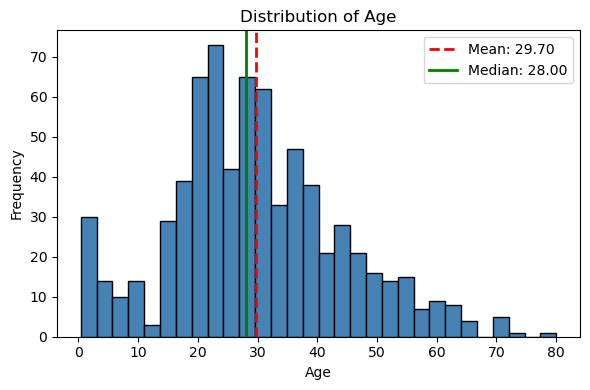

In [1083]:
plot_numeric_histogram(titanic_df, 'Age')

Usuwam braki zgodnie z aktualnie panującym rozkładem, żeby nie zaburzać proporcji:

In [1084]:
def get_column_distribution(df, column):
  return df[column].value_counts(normalize=True)

age_count_prob = get_column_distribution(titanic_df, 'Age')
age_values = age_count_prob.index
age_probs = age_count_prob.values
missing_age_vals = titanic_df.Age.isna()
titanic_df.loc[missing_age_vals, 'Age'] = np.random.choice(age_values, size=missing_age_vals.sum(), p=age_probs)

In [1085]:
titanic_df.Age.isna().sum()

0

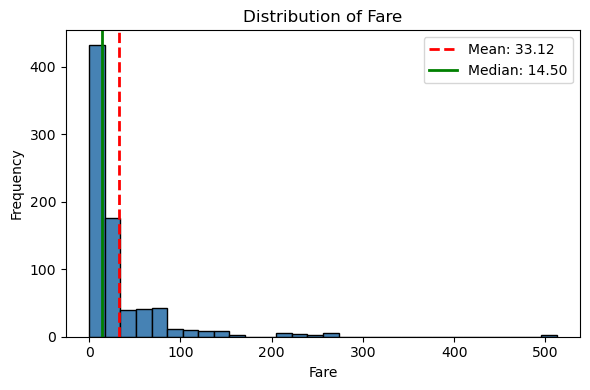

In [1086]:
plot_numeric_histogram(titanic_df, 'Fare')


Rozkład jest asymetryczny, więc  uzupełniam medianą:

In [1087]:
titanic_df['Fare'] = titanic_df['Fare'].fillna(titanic_df['Fare'].median())

Sprawdzam rozkład liczności poszczególnych portów:

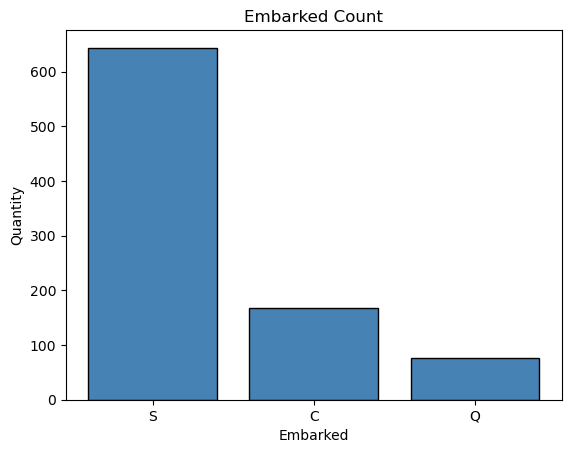

In [1088]:
counts = titanic_df['Embarked'].value_counts()
categories = counts.index
values = counts.values
plt.bar(categories, values, color='steelblue', edgecolor='black')
plt.title("Embarked Count")
plt.xlabel("Embarked")
plt.ylabel("Quantity")
plt.show()

In [1089]:
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0]) # brakujące wartości uzupeniam modą, bo dominuje jeden port

Zmieniam dane kolumnie 'Sex' na kod binarny (są dwie odpowiedzi):

In [1090]:
titanic_df.Sex.unique()

array(['male', 'female'], dtype=object)

In [1091]:
titanic_df['Sex'] = titanic_df.Sex.map({
    'male': 0,
    'female': 1
})
titanic_df['Sex'].value_counts()

Sex
0    577
1    314
Name: count, dtype: int64

Zmieniam dane w kolumnie 'Embarked' na etykiety (są trzy odpowiedzi):

In [1092]:
titanic_df.Embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

In [1093]:
titanic_df['Embarked'] = titanic_df.Embarked.map({
    'S': 0,
    'C': 1,
    'Q': 2
})
titanic_df['Embarked'].value_counts()

Embarked
0    646
1    168
2     77
Name: count, dtype: int64

Tworzę nową kolumnę, z podziałem na grupy wiekowe:

In [1094]:
labels = ['Child', 'Young Adult', 'Adult', 'Senior']
life_stages = [
    (titanic_df['Age'] < 18),
    (titanic_df['Age'] >= 18) & (titanic_df['Age'] < 30),
    (titanic_df['Age'] >= 30) & (titanic_df['Age'] < 60),
    (titanic_df['Age'] >= 60)
]
titanic_df['Life Stage'] = np.select(life_stages, labels)

In [1095]:
titanic_df['Life Stage'] = titanic_df['Life Stage'].map({
    'Child': 0 ,
    'Young Adult': 1,
    'Adult': 2,
    'Senior': 3
})
titanic_df['Life Stage'].value_counts()

Life Stage
2    368
1    346
0    141
3     36
Name: count, dtype: int64

Tworzę nową kolumnę z rozmiarem rodziny na statku:

In [1096]:
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1

## Wizualizacje

In [1097]:
def plot_categorical_column(df, column_name):
    counts = df['FamilySize'].value_counts()

    plt.figure(figsize=(6, 5))
    counts.plot(kind='bar', color='steelblue', edgecolor='black')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

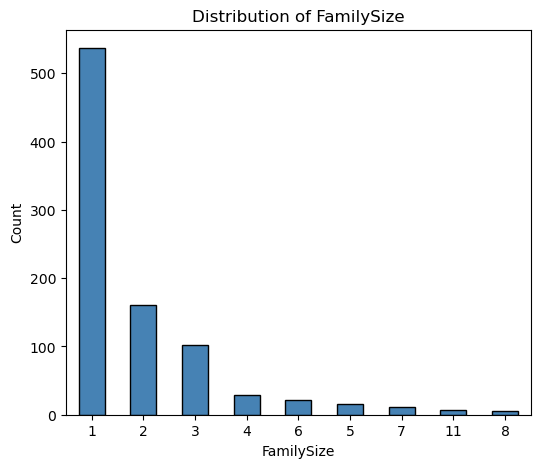

In [1104]:
plot_categorical_column(titanic_df, 'FamilySize')

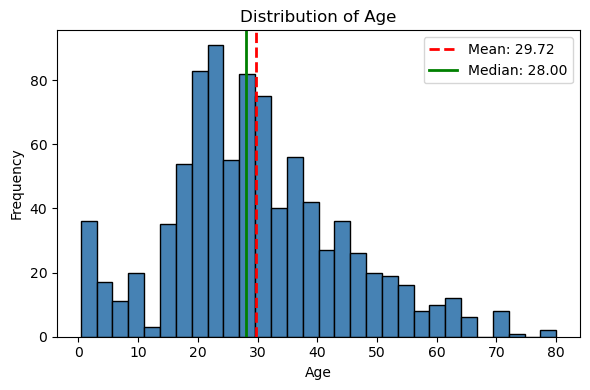

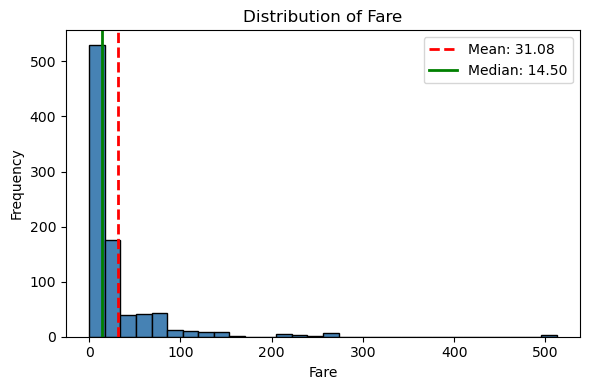

In [1107]:
plot_numeric_histogram(titanic_df, 'Age')
plot_numeric_histogram(titanic_df, 'Fare')

In [ ]:
def boxplot(df, column_name):
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[column_name].dropna(), color='lightgreen')
    plt.title(f'Distribution of {column_name} (boxplot)')
    plt.xlabel(column_name)
    plt.show()

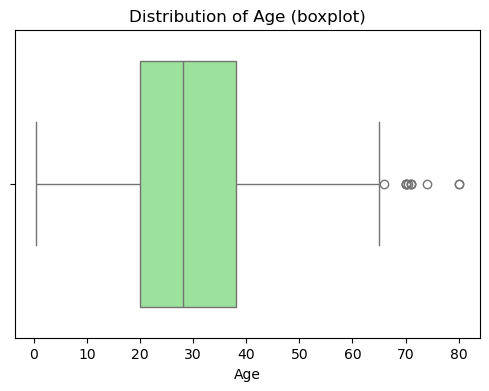

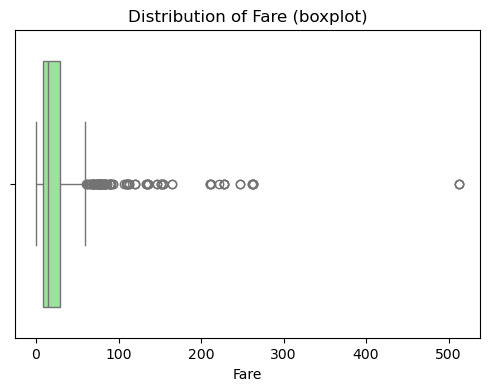

In [1110]:
boxplot(titanic_df, 'Age')
boxplot(titanic_df, 'Fare')

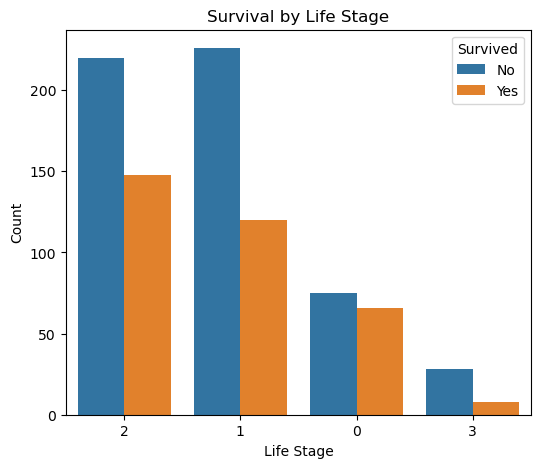

In [1099]:
def survival_by_category(df, column_name):
    plt.figure(figsize=(6, 5))
    sns.countplot(data= df, x= column_name, hue='Survived', order=df[column_name].value_counts().index)
    plt.title(f'Survival by {column_name}')
    plt.xlabel(f'{column_name}')
    plt.ylabel('Count')
    plt.legend(title='Survived', labels=['No', 'Yes'])
    plt.show()

survival_by_category(titanic_df, 'Life Stage')

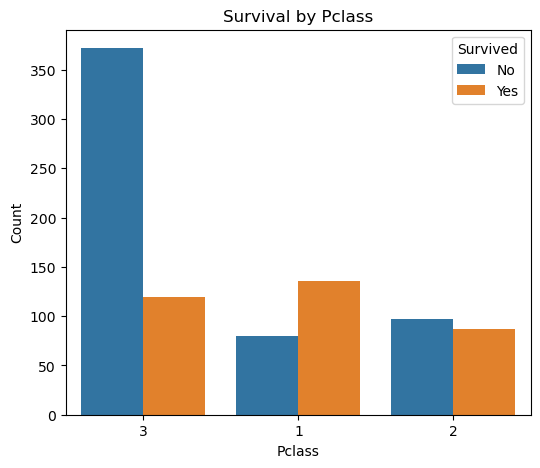

In [1100]:
survival_by_category(titanic_df, 'Pclass')

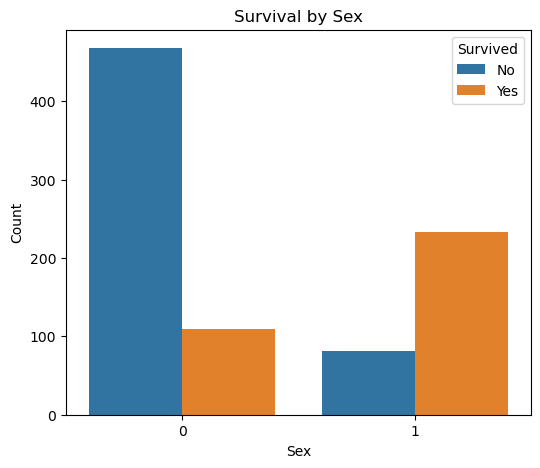

In [1101]:
survival_by_category(titanic_df, 'Sex')

Heatmapa (pomocnicza)

In [1102]:
def plot_correlation_matrix(df):
    corr = df.corr(numeric_only=True)

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

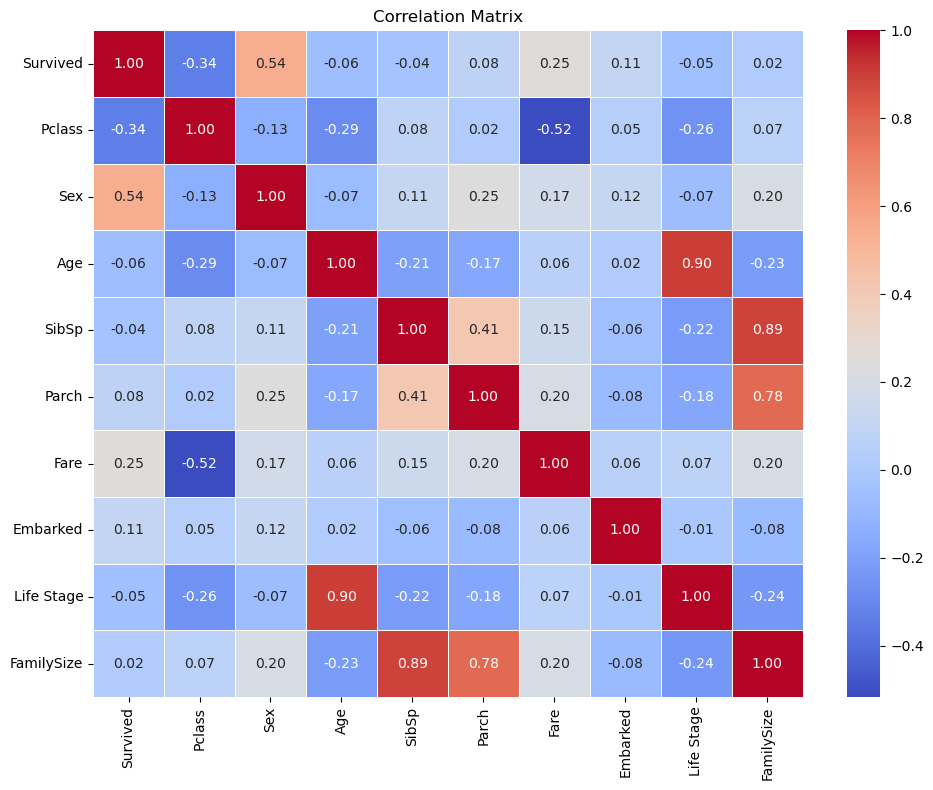

In [1103]:
plot_correlation_matrix(titanic_df)